### Libraries

In [1]:
!pip install steamreviews

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install emot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 14 kB/s 


In [3]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 14.4 MB/s 
     |████████████████████████████████| 106 kB 48.6 MB/s 


In [4]:
!pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 2.2 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [6]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 4.8 MB/s 
     |████████████████████████████████| 1.1 MB 41.5 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=cd7544a993551de00de320afbc698a248e58ede1fbd543656b6fb6c1b0509fd0
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=c18de771203a5e7777a0593a6f31b6ad7c011110539dd6a531e82cb1981799b3
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [7]:
import steamreviews
import json
from datetime import datetime, timezone
import pandas as pd
import numpy as np
import re
import pickle
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO
import contractions
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import string
import warnings
warnings.filterwarnings("ignore")
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim import models
#from gensim.models.tfidfmodel import Tfidfmodel
from gensim.models.nmf import Nmf
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import operator
from gensim.models import Phrases
from gensim.models.phrases import Phraser

In [8]:
spacy.cli.download('en_core_web_lg')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [9]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

### Scraping steam user reviews

In [ ]:
#define parameters for steamviews to download relevant reviews
request_params = dict()
request_params['language'] = 'english'
request_params['filter'] = 'recent'

app_id = 1145360
review_dict, query_count = steamreviews.download_reviews_for_app_id(
    app_id,
    chosen_request_params=request_params
    )

In [10]:
#load the json file
with open('/content/drive/MyDrive/Colab Notebooks/IRTM/review_1145360.json') as f:
    dataset = json.load(f)

reviews = [i for i in dataset['reviews'].values()]
print('Number of downloaded reviews:', len(reviews))

#check the day range of the dataset
created_time = []
for i in range(len(reviews)):
    created_time += [reviews[i]['timestamp_created']]

#timezone is utc
review_earliest = datetime.fromtimestamp(
    min(created_time),
    tz = timezone.utc
    ).strftime('%Y-%m-%d %H:%M:%S')

review_latest = datetime.fromtimestamp(
    max(created_time),
    tz = timezone.utc
    ).strftime('%Y-%m-%d %H:%M:%S')

print('The earliest review in the dataset was created:{}\nThe latest review in the dataset was created:{}'.format(review_earliest, review_latest))

Number of downloaded reviews: 99985
The earliest review in the dataset was created:2019-12-10 18:32:54
The latest review in the dataset was created:2022-05-18 19:01:08


In [11]:
#preview the data
reviews[0]

{'author': {'last_played': 1652895467,
  'num_games_owned': 39,
  'num_reviews': 4,
  'playtime_at_review': 2393,
  'playtime_forever': 2393,
  'playtime_last_two_weeks': 2393,
  'steamid': '76561198128047884'},
 'comment_count': 0,
 'language': 'english',
 'received_for_free': False,
 'recommendationid': '115653941',
 'review': "First rogue-lite game I have ever played, and couldn't be happier.",
 'steam_purchase': True,
 'timestamp_created': 1652900468,
 'timestamp_updated': 1652900468,
 'voted_up': True,
 'votes_funny': 0,
 'votes_up': 0,
 'weighted_vote_score': 0,
 'written_during_early_access': False}

In [12]:
#convert json to dataframe
#the definiton of response can be checked here: https://partner.steamgames.com/doc/store/getreviews
with open('/content/drive/MyDrive/Colab Notebooks/IRTM/review_1145360.json', 'r') as f:
    data = json.loads(f.read())
    ds = data['reviews'].values()
df = pd.json_normalize(ds)

In [13]:
#change the format of playtime into hours
df['author.playtime_forever']=df['author.playtime_forever']/60
df['author.playtime_last_two_weeks']=df['author.playtime_last_two_weeks']/60
df['author.playtime_at_review']=df['author.playtime_at_review']/60

#count the words in each review
review_wordcount = df['review'].str.split().str.len()
df.insert(3, 'review_wordcount', review_wordcount)
df.head()

,recommendationid,language,review,review_wordcount,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,...,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played,timestamp_dev_responded,developer_response
0,115653941,english,"First rogue-lite game I have ever played, and ...",11,1652900468,1652900468,True,0,0,0,...,False,76561198128047884,39,4,39.883333,39.883333,39.883333,1652895467,NaN,NaN
1,115653584,english,Yes,1,1652899952,1652899952,True,0,0,0,...,False,76561198215754604,88,18,13.216667,0.000000,13.216667,1641511484,NaN,NaN
2,115651857,english,Great game and story for a rouge-lite!,7,1652897468,1652897468,True,0,0,0,...,False,76561198098996727,34,2,33.683333,19.150000,33.683333,1652897438,NaN,NaN
3,115646370,english,hay,1,1652889176,1652889176,True,0,0,0,...,False,76561198818706437,7,2,3.766667,0.000000,3.766667,1641403274,NaN,NaN
4,115644916,english,"The best Rogue like experience, gameplay is su...",29,1652887046,1652887046,True,0,0,0,...,False,76561198804623431,1,1,60.216667,43.100000,56.633333,1652902398,NaN,NaN


###Text cleaning

In [14]:
#drop the reviews that were written within 2 hours of playtime and the reviews that wordcount number is under 25th percentile of overall word count
df1 = df[(df['author.playtime_at_review'] >= 2) & (df['review_wordcount'] >= np.percentile(df['review_wordcount'], 25))]
df1 = df1.reset_index(drop = True)
df1.describe()

,review_wordcount,timestamp_created,timestamp_updated,votes_up,votes_funny,comment_count,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played,timestamp_dev_responded
count,78092.000000,7.809200e+04,7.809200e+04,78092.000000,78092.000000,78092.000000,78092.000000,78092.000000,78092.000000,78092.000000,78092.000000,7.809200e+04,1.000000e+01
mean,40.987374,1.610577e+09,1.611301e+09,1.057842,0.282026,0.023792,227.070532,12.203132,79.530335,0.358211,39.989417,1.628441e+09,1.581364e+09
std,79.361122,1.623573e+07,1.623695e+07,20.548486,10.070583,0.462633,329.224329,26.744676,89.267489,3.367358,53.878600,1.707046e+07,7.175223e+06
min,3.000000,1.576009e+09,1.576011e+09,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,0.000000,2.000000,1.576091e+09,1.576609e+09
25%,7.000000,1.602780e+09,1.603505e+09,0.000000,0.000000,0.000000,61.000000,2.000000,29.433333,0.000000,10.100000,1.612149e+09,1.579752e+09
50%,17.000000,1.606874e+09,1.607235e+09,0.000000,0.000000,0.000000,136.000000,6.000000,60.200000,0.000000,24.008333,1.630572e+09,1.579769e+09
75%,42.000000,1.616982e+09,1.618024e+09,0.000000,0.000000,0.000000,275.000000,13.000000,103.100000,0.000000,51.966667,1.643751e+09,1.579769e+09
max,1757.000000,1.652900e+09,1.652900e+09,2175.000000,1530.000000,40.000000,11003.000000,2798.000000,3893.383333,324.100000,3636.116667,1.652905e+09,1.601497e+09


In [15]:
#convert emojis and emoticons to words
def convertEmojis(text):
    for emot in UNICODE_EMOJI:
        text = text.replace(emot, "_".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split()))
    return text

def convertEmoticons(text):
    for emot in EMOTICONS_EMO:
        text = text.replace(emot, EMOTICONS_EMO[emot].replace(" ","_"))
    return text

#process contractions
def removeContractions(text):
    for k, v in contractions.contractions_dict.items():
        text = text.replace(k, v)
    return text

#clean reviews format
def cleanFormat(text):
    text = text.lower()
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\[.*?\]', '', text)      
    text = re.sub(r'https*\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'\w*\d+\w*', '', text)
    return text

#replace repitition terms
def replaceRepition(text):
    text = re.sub(r'(.)\1+', r'\1\1', text)
    text = re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)
    return text

#combine above functions
def textCleaning(text):
    text = convertEmojis(text)
    text = convertEmoticons(text)
    text = removeContractions(text)
    text = cleanFormat(text)
    text = replaceRepition(text)
    return text



In [16]:
df1['cleaned_review'] = df1['review'].apply(lambda x: textCleaning(x))
df1.head()

,recommendationid,language,review,review_wordcount,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,...,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played,timestamp_dev_responded,developer_response,cleaned_review
0,115653941,english,"First rogue-lite game I have ever played, and ...",11,1652900468,1652900468,True,0,0,0,...,76561198128047884,39,4,39.883333,39.883333,39.883333,1652895467,NaN,NaN,"first rogue-lite game i have ever played, and ..."
1,115651857,english,Great game and story for a rouge-lite!,7,1652897468,1652897468,True,0,0,0,...,76561198098996727,34,2,33.683333,19.150000,33.683333,1652897438,NaN,NaN,great game and story for a rouge-lite!
2,115644916,english,"The best Rogue like experience, gameplay is su...",29,1652887046,1652887046,True,0,0,0,...,76561198804623431,1,1,60.216667,43.100000,56.633333,1652902398,NaN,NaN,"the best rogue like experience, gameplay is su..."
3,115644188,english,"very awesome game, try it out for sure",8,1652885986,1652885986,True,0,0,0,...,76561198182964853,58,37,11.866667,0.666667,11.200000,1652888374,NaN,NaN,"very awesome game, try it out for sure"
4,115643378,english,Pros:\nEverything except Dusa\n\nCons:\nDusa,6,1652884784,1652884784,True,0,0,0.47826087474822998,...,76561198186416150,178,5,77.583333,25.133333,74.833333,1652894966,NaN,NaN,pros:everything except dusacons:dusa


In [17]:
#split reviews into sentences
nlp = spacy.load('en_core_web_lg')
def splitSent(text):
    doc = nlp(text)
    for i in doc.sents:
        sentences = i.text
    return sentences

dfsplit = pd.DataFrame()
dfsplit['reviewsents'] = df1['cleaned_review'].apply(lambda x : splitSent(x))
dfsplit.head()

,reviewsents
0,"first rogue-lite game i have ever played, and ..."
1,great game and story for a rouge-lite!
2,"the best rogue like experience, gameplay is su..."
3,"very awesome game, try it out for sure"
4,pros:everything except dusacons:dusa


In [18]:
dfsplit.iloc[0,:]

reviewsents    first rogue-lite game i have ever played, and ...
Name: 0, dtype: object

In [19]:
#remove punctuation
def removePunc(text):
    text = ''.join(i for i in text if i not in string.punctuation)
    return text

dfsplit['nopunc'] = dfsplit['reviewsents'].apply(lambda x : removePunc(x))

In [20]:
dfsplit

,reviewsents,nopunc
0,"first rogue-lite game i have ever played, and ...",first roguelite game i have ever played and co...
1,great game and story for a rouge-lite!,great game and story for a rougelite
2,"the best rogue like experience, gameplay is su...",the best rogue like experience gameplay is sup...
3,"very awesome game, try it out for sure",very awesome game try it out for sure
4,pros:everything except dusacons:dusa,proseverything except dusaconsdusa
...,...,...
78087,", i just hope the next game will be more acces...",i just hope the next game will be more access...
78088,"prepare to die, laugh and explore a world wher...",prepare to die laugh and explore a world where...
78089,the gameplay is really fun,the gameplay is really fun
78090,no more,no more


### Tokenization and lemmatization





In [21]:
def tokenization(text):
    doc = nlp(text)
    tokenlist = []
    
    for token in doc:
        tokenlist.append(token.text)
    
    sentences = []
    
    for word in tokenlist:
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            sentences.append(word)
    return sentences

In [22]:
dfsplit['tokenization'] = dfsplit['nopunc'].apply(lambda x : tokenization(x))
dfsplit.head()

,reviewsents,nopunc,tokenization
0,"first rogue-lite game i have ever played, and ...",first roguelite game i have ever played and co...,"[roguelite, game, played, happier]"
1,great game and story for a rouge-lite!,great game and story for a rougelite,"[great, game, story, rougelite]"
2,"the best rogue like experience, gameplay is su...",the best rogue like experience gameplay is sup...,"[best, rogue, like, experience, gameplay, supe..."
3,"very awesome game, try it out for sure",very awesome game try it out for sure,"[awesome, game, try, sure]"
4,pros:everything except dusacons:dusa,proseverything except dusaconsdusa,"[proseverything, dusaconsdusa]"


In [23]:
def lemmatization(text):
    text = ' '.join(map(str, text))
    doc = nlp(text)
    lemmalist = []
    for token in doc:
        lemmalist.append(token.lemma_)
    return lemmalist
dfsplit['lemmatization'] = dfsplit['tokenization'].apply(lambda x: lemmatization(x))

In [24]:
dfsplit.head()

,reviewsents,nopunc,tokenization,lemmatization
0,"first rogue-lite game i have ever played, and ...",first roguelite game i have ever played and co...,"[roguelite, game, played, happier]","[roguelite, game, play, happy]"
1,great game and story for a rouge-lite!,great game and story for a rougelite,"[great, game, story, rougelite]","[great, game, story, rougelite]"
2,"the best rogue like experience, gameplay is su...",the best rogue like experience gameplay is sup...,"[best, rogue, like, experience, gameplay, supe...","[good, rogue, like, experience, gameplay, supe..."
3,"very awesome game, try it out for sure",very awesome game try it out for sure,"[awesome, game, try, sure]","[awesome, game, try, sure]"
4,pros:everything except dusacons:dusa,proseverything except dusaconsdusa,"[proseverything, dusaconsdusa]","[proseverything, dusaconsdusa]"


### Sentiment analysis

In [25]:
sid = SentimentIntensityAnalyzer()
dfsplit['allscores'] = dfsplit['nopunc'].apply(lambda x : sid.polarity_scores(x))
dfsplit['comp_score'] = dfsplit['allscores'].apply(lambda x : x['compound'])
dfsplit.head()

,reviewsents,nopunc,tokenization,lemmatization,allscores,comp_score
0,"first rogue-lite game i have ever played, and ...",first roguelite game i have ever played and co...,"[roguelite, game, played, happier]","[roguelite, game, play, happy]","{'neg': 0.196, 'neu': 0.635, 'pos': 0.169, 'co...",-0.0966
1,great game and story for a rouge-lite!,great game and story for a rougelite,"[great, game, story, rougelite]","[great, game, story, rougelite]","{'neg': 0.0, 'neu': 0.549, 'pos': 0.451, 'comp...",0.6249
2,"the best rogue like experience, gameplay is su...",the best rogue like experience gameplay is sup...,"[best, rogue, like, experience, gameplay, supe...","[good, rogue, like, experience, gameplay, supe...","{'neg': 0.0, 'neu': 0.586, 'pos': 0.414, 'comp...",0.9109
3,"very awesome game, try it out for sure",very awesome game try it out for sure,"[awesome, game, try, sure]","[awesome, game, try, sure]","{'neg': 0.0, 'neu': 0.473, 'pos': 0.527, 'comp...",0.7713
4,pros:everything except dusacons:dusa,proseverything except dusaconsdusa,"[proseverything, dusaconsdusa]","[proseverything, dusaconsdusa]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000


In [26]:
def score2label(x):
    if x > 0:
        return 'positive'
    elif x == 0:
        return 'neutral'
    else:
        return 'negative'
dfsplit['label'] = dfsplit['comp_score'].apply(lambda x : score2label(x))
dfsplit.head()

,reviewsents,nopunc,tokenization,lemmatization,allscores,comp_score,label
0,"first rogue-lite game i have ever played, and ...",first roguelite game i have ever played and co...,"[roguelite, game, played, happier]","[roguelite, game, play, happy]","{'neg': 0.196, 'neu': 0.635, 'pos': 0.169, 'co...",-0.0966,negative
1,great game and story for a rouge-lite!,great game and story for a rougelite,"[great, game, story, rougelite]","[great, game, story, rougelite]","{'neg': 0.0, 'neu': 0.549, 'pos': 0.451, 'comp...",0.6249,positive
2,"the best rogue like experience, gameplay is su...",the best rogue like experience gameplay is sup...,"[best, rogue, like, experience, gameplay, supe...","[good, rogue, like, experience, gameplay, supe...","{'neg': 0.0, 'neu': 0.586, 'pos': 0.414, 'comp...",0.9109,positive
3,"very awesome game, try it out for sure",very awesome game try it out for sure,"[awesome, game, try, sure]","[awesome, game, try, sure]","{'neg': 0.0, 'neu': 0.473, 'pos': 0.527, 'comp...",0.7713,positive
4,pros:everything except dusacons:dusa,proseverything except dusaconsdusa,"[proseverything, dusaconsdusa]","[proseverything, dusaconsdusa]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral


In [27]:
port_pos = ((dfsplit.label.values == 'positive').sum())/dfsplit.shape[0]
port_neu = ((dfsplit.label.values == 'neutral').sum())/dfsplit.shape[0]
port_neg = ((dfsplit.label.values == 'negative').sum())/dfsplit.shape[0]
print('The proportion of positive, neutral and negative label: {}, {}, {} '. format(port_pos, port_neu, port_neg))

The proportion of positive, neutral and negative label: 0.6597346719254213, 0.22943451313834964, 0.11083081493622907 


In [28]:
#change the threshold
def score2label(x):
    if x > 0.1:
        return 'positive'
    elif x < -0.1:
        return 'negative'
    else:
        return 'neutral'
dfsplit['label2'] = dfsplit['comp_score'].apply(lambda x : score2label(x))
port_pos = ((dfsplit.label2.values == 'positive').sum())/dfsplit.shape[0]
port_neu = ((dfsplit.label2.values == 'neutral').sum())/dfsplit.shape[0]
port_neg = ((dfsplit.label2.values == 'negative').sum())/dfsplit.shape[0]
print('The proportion of positive, neutral and negative label: {}, {}, {} '. format(port_pos, port_neu, port_neg))

The proportion of positive, neutral and negative label: 0.6445090406187574, 0.2531757414331814, 0.10231521794806125 


### Topic modelling

In [29]:
#add stopwords
mystopwords = list(set(STOP_WORDS))
mystopwords.extend(['game','time', 'great', 'good', 'play', 'hour', 'love', 'fun'])

def removeStopwords(text):
    text = [i for i in text if i not in mystopwords and len(i) >= 1 and i != '' and i != ' ']
    return text

#create ngram
bigram = Phrases(list(dfsplit['lemmatization']))
for i in dfsplit['lemmatization']:
    bigram_sents = u' '.join(bigram[i]) 
    
trigram = Phrases(bigram_sents)

bi_model = Phraser(bigram)
tri_model = Phraser(trigram)

def createBigram(text):
    return [bi_model[i] for i in text]

def createTrigram(text):
    return [tri_model[bi_model[i]] for i in text]

#fliter tokens by pos tags
def fliterPos(text, postags):
    words = nlp(' '.join(text))
    lemma_pos = [i.text if '_' in i.text else i.lemma_ if i.pos_ in postags else '' for i in words]
    #lemma_pos = [i.text if i.pos_ in postags else '' for i in words]
    return lemma_pos


In [30]:
dfsplit['tri_token'] = createTrigram(dfsplit['lemmatization'])
dfsplit['tri_noun'] = dfsplit['tri_token'].apply(lambda x: fliterPos(x, postags = ['NOUN']))

In [31]:
dfsplit['new_trinoun'] = dfsplit['tri_noun'].apply(lambda x: removeStopwords(x))
dfsplit['new_tritoken'] = dfsplit['tri_token'].apply(lambda x: removeStopwords(x))
#dg = dfsplit.loc[:, ]

In [32]:
dfsplit.dropna(inplace=True)
data1 = dfsplit.drop(dfsplit[dfsplit['new_trinoun'].map(lambda x : len(x) < 2)].index)
data1.reset_index(drop = True)
data1.head()

,reviewsents,nopunc,tokenization,lemmatization,allscores,comp_score,label,label2,tri_token,tri_noun,new_trinoun,new_tritoken
2,"the best rogue like experience, gameplay is su...",the best rogue like experience gameplay is sup...,"[best, rogue, like, experience, gameplay, supe...","[good, rogue, like, experience, gameplay, supe...","{'neg': 0.0, 'neu': 0.586, 'pos': 0.414, 'comp...",0.9109,positive,positive,"[good, rogue_like, experience, gameplay, super...","[, rogue_like, experience, gameplay, , , voice...","[rogue_like, experience, gameplay, voice_actor...","[rogue_like, experience, gameplay, super, smoo..."
5,"in the words of the boys ""this sh*t bussin, re...",in the words of the boys this sht bussin respe...,"[words, boys, sht, bussin, respectfully]","[word, boy, sht, bussin, respectfully]","{'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'comp...",0.4019,positive,positive,"[word, boy, sht, bussin, respectfully]","[word, , sht, , ]","[word, sht]","[word, boy, sht, bussin, respectfully]"
6,personally i see hades' story and aesthetic as...,personally i see hades story and aesthetic as ...,"[personally, hades, story, aesthetic, second, ...","[personally, hades, story, aesthetic, second, ...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,neutral,"[personally, hades, story, aesthetic, second, ...","[, , story, , , generation, experiment, pyre]","[story, generation, experiment, pyre]","[personally, hades, story, aesthetic, second, ..."
7,"/ for the selection of ""vanquished"" text alone",for the selection of vanquished text alone,"[ , selection, vanquished, text]","[ , selection, vanquish, text]","{'neg': 0.25, 'neu': 0.75, 'pos': 0.0, 'compou...",-0.2500,negative,negative,"[ , selection, vanquish, text]","[, selection, , text]","[selection, text]","[ , selection, vanquish, text]"
9,"all the way, man.",all the way man,"[way, man]","[way, man]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,neutral,"[way, man]","[way, man]","[way, man]","[way, man]"


In [33]:
texts = list(data1['new_trinoun'])
dct = Dictionary(texts)
dct.filter_extremes(no_below = 2, no_above = 0.95)
corpus = [dct.doc2bow(text) for text in texts]

tfidf = models.tfidfmodel.TfidfModel(corpus)
vector = tfidf[corpus]

4


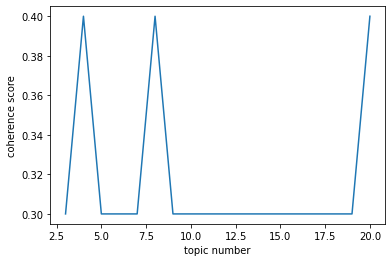

In [34]:
#find the best topic number
#code refers to this blog https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45
topic_num = list(np.arange(3, 21, 1))
coherence = []

for i in topic_num:
    nmfmodel = Nmf(
        corpus,
        num_topics = i,
        id2word = dct,
        normalize = True,
        random_state = 12345
        )
    cohermodel = CoherenceModel(
        model = nmfmodel,
        texts = texts,
        dictionary = dct,
        coherence = 'c_v'
    )
    coherence.append(round(cohermodel.get_coherence(), 1))
#get the topic number with higest coherence score
scores = list(zip(topic_num, coherence))
besttopicnum = sorted(scores, key = operator.itemgetter(1), reverse = True)[0][0]
print(besttopicnum)

plt.plot(topic_num, coherence)
plt.xlabel('topic number')
plt.ylabel('coherence score')
plt.show()

In [35]:
#generate topics with the best topic number
nmf_update = Nmf(
    corpus,
    num_topics = 8,
    id2word = dct,
    normalize = True,
    random_state = 12345
    )

num_topics = 8
nmfgen_dict = {}
for i in range(num_topics):
    #print('The top 20 words for topic {}'.format(i + 1))
    words = nmf_update.show_topic(i, topn = 20)
    key = 'Topic {}'.format(i + 1)
    value = [i[0] for i in words]
    nmfgen_dict[key] = value
dfnmfgen = pd.DataFrame(nmfgen_dict)
display(dfnmfgen)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
0,_,gameplay,story,character,run,_,art,genre
1,▓,story,roguelike,story,thing,⢸,music,roguelike
2,░,supergiant,lot,music,way,⠀,voice_act,soundtrack
3,▒,mechanic,combat,dialogue,year,⠉,design,way
4,▀,art_style,mechanic,combat,weapon,⡌,work,highly_recommend
5,⠀,style,experience,progression,upgrade,⠈,combat,thing
6,⠇,voice_act,people,art_style,boss,⠇,gameplay,price
7,mechanic,soundtrack,action,weapon,replayability,⣀,dialogue,fan
8,u_u,storyline,progression,voice_act,stuff,hrs,voice_acting,gameplay
9,recommend,music,progress,voice_acting,lot,way,greek_mythology,bit


### NMF with sklearn

In [36]:
tfidf_sk = TfidfVectorizer(analyzer = 'word',
                        ngram_range = (1, 3),
                        max_df=0.95,
                        min_df=2,
                        use_idf=True,
                        norm='l2'
                        )

In [37]:
def newstop(text):
    nlp.Defaults.stop_words |= {'game','time', 'great', 'good', 'play', 'hour', 'love', 'fun'}
    newlemma = []
    for word in nlp.Defaults.stop_words:
        lex = nlp.vocab[word]
        lex.is_stop = True
    for word in text:
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            if word != '':
                newlemma.append(word)
    return newlemma
data_sk = pd.DataFrame()
data_sk['newlemma'] = data1['new_trinoun'].apply(lambda x: newstop(x))
data_sk['comp_score'] = data1['comp_score']
data_sk['label'] = data1['label2']
data_sk['reviewsents'] = data1['reviewsents']

In [38]:
data_sk = data_sk.drop(data_sk[data_sk['newlemma'].map(lambda x : len(x) < 2)].index)
data_sk.reset_index(drop=True)

,newlemma,comp_score,label,reviewsents
0,"[rogue_like, experience, gameplay, voice_actor...",0.9109,positive,"the best rogue like experience, gameplay is su..."
1,"[word, sht]",0.4019,positive,"in the words of the boys ""this sh*t bussin, re..."
2,"[story, generation, experiment, pyre]",0.0000,neutral,personally i see hades' story and aesthetic as...
3,"[selection, text]",-0.2500,negative,"/ for the selection of ""vanquished"" text alone"
4,"[way, man]",0.0000,neutral,"all the way, man."
...,...,...,...,...
26197,"[nt_wait, release]",0.0000,neutral,can't wait for the full release
26198,"[dark_souls, diablo, cancer]",-0.4404,negative,or you could just say its like the dark souls ...
26199,"[highly_recommend, enjoy, genre]",0.7178,positive,highly recommend this game if you enjoy other ...
26200,"[die, world, voice, havoc, hell]",-0.8428,negative,"prepare to die, laugh and explore a world wher..."


In [39]:
datatm_sk = data_sk['newlemma'].apply(lambda x: ' '.join(x))
tm_sk = tfidf_sk.fit_transform(datatm_sk)
nmf_sk = NMF(init='random', n_components = 8, random_state = 12345)
nmf_sk.fit(tm_sk)

NMF(init='random', n_components=8, random_state=12345)

In [40]:
nmfsk_dict = {}
feature_names = tfidf_sk.get_feature_names()
for index, topic in enumerate(nmf_sk.components_):
    key = 'Topic {}'.format(index + 1)
    #get index positions of the top 20 words with greatest coefficient value
    features_id = topic.argsort()[::-1][:20] 
    features = [feature_names[i] for i in features_id]
    nmfsk_dict[key] = features
dfnmfsk = pd.DataFrame(nmfsk_dict)
display(dfnmfsk)


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
0,music,character,gameplay,story,roguelike,supergiant,year,lot
1,art,story character,story gameplay,story gameplay,genre,masterpiece,ve_play,content
2,art music,character story,gameplay story,mechanic,roguelike story,work,roguelike year,way
3,voice_act,character gameplay,soundtrack,story character,action,job,ve_play year,thing
4,story music,dialogue,music gameplay,combat,action roguelike,soundtrack,year year,lot content
5,music art,character dialogue,character gameplay,roguelike story,roguelike ve_play,work supergiant,release,early_access
6,music gameplay,interaction,soundtrack gameplay,gameplay story,roguelike genre,job supergiant,early_access,combat
7,music story,art_style,art_style,story mechanic,ve_play,masterpiece supergiant,rogue_like,weapon
8,story art,interaction character,art_style gameplay,story music,fan,highly_recommend,purchase year,run
9,art story,voice_act,art gameplay,progression,highly_recommend,look_forward,purchase,price


In [41]:
#give the topic label
topic_results = nmf_sk.transform(tm_sk)
data_sk['Topic_num'] = topic_results.argmax(axis = 1)+1
topic_dict = {1:'Visual Style and Music',
              2:'Characters',
              3:'Gameplay',
              4:'Story and Narrative',
              5:'Genre and Differences',
              6:'Developer and Publisher',
              7:'Awards',
              8:'Task and Game Mechanics'
              }
data_sk['Topic'] = data_sk['Topic_num'].map(topic_dict)
data_sk.to_csv('/content/drive/MyDrive/Colab Notebooks/IRTM/data_sk.csv')
data_sk.head()

,newlemma,comp_score,label,reviewsents,Topic_num,Topic
2,"[rogue_like, experience, gameplay, voice_actor...",0.9109,positive,"the best rogue like experience, gameplay is su...",2,Characters
5,"[word, sht]",0.4019,positive,"in the words of the boys ""this sh*t bussin, re...",1,Visual Style and Music
6,"[story, generation, experiment, pyre]",0.0000,neutral,personally i see hades' story and aesthetic as...,4,Story and Narrative
7,"[selection, text]",-0.2500,negative,"/ for the selection of ""vanquished"" text alone",8,Task and Game Mechanics
9,"[way, man]",0.0000,neutral,"all the way, man.",8,Task and Game Mechanics


### Topic modelling based on tri_token instead of tri_noun

In [42]:
data2 = dfsplit.drop(dfsplit[dfsplit['new_tritoken'].map(lambda x : len(x) < 2)].index)
data2.reset_index(drop = True)

texts2 = list(data2['new_tritoken'])
dct2 = Dictionary(texts2)
dct2.filter_extremes(no_below = 2, no_above = 0.95)
corpus2 = [dct2.doc2bow(text) for text in texts2]

tfidf2 = models.tfidfmodel.TfidfModel(corpus2)
vector2 = tfidf2[corpus2]

5


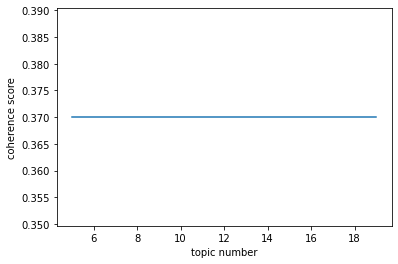

In [43]:
topic_num = list(np.arange(5, 21, 2))
coherence2 = []

for i in topic_num:
    nmfmodel2 = Nmf(
        corpus2,
        num_topics = i,
        id2word = dct2,
        normalize = True,
        random_state = 12345
        )
    cohermodel2 = CoherenceModel(
        model = nmfmodel2,
        texts = texts2,
        dictionary = dct2,
        coherence = 'c_v'
    )
    coherence2.append(round(cohermodel.get_coherence(), 2))
#get the topic number with higest coherence score
scores2 = list(zip(topic_num, coherence2))
besttopicnum2 = sorted(scores2, key = operator.itemgetter(1), reverse = True)[0][0]
print(besttopicnum2)

plt.plot(topic_num, coherence2)
plt.xlabel('topic number')
plt.ylabel('coherence score')
plt.show()

In [44]:
data_sk22 = pd.DataFrame()
data_sk22['newlemma'] = data2['new_tritoken'].apply(lambda x: newstop(x))
data_sk22['comp_score'] = data2['comp_score']
data_sk22['label'] = data2['label']

In [45]:
data_sk22 = data_sk22.drop(data_sk22[data_sk22['newlemma'].map(lambda x : len(x) < 2)].index)
data_sk22.reset_index(drop=True)

,newlemma,comp_score,label
0,"[roguelite, happy]",-0.0966,negative
1,"[story, rougelite]",0.6249,positive
2,"[rogue_like, experience, gameplay, super, smoo...",0.9109,positive
3,"[awesome, try, sure]",0.7713,positive
4,"[proseverything, dusaconsdusa]",0.0000,neutral
...,...,...,...
55859,"[easy, difficult_master]",-0.3182,negative
55860,"[highly_recommend, enjoy, genre]",0.7178,positive
55861,"[ , hope, accessible, beginning]",0.4404,positive
55862,"[prepare, die, laugh, explore, world, voice, b...",-0.8428,negative


In [46]:
datatm_sk2 = data_sk22['newlemma'].apply(lambda x: ' '.join(x))
tm_sk2 = tfidf_sk.fit_transform(datatm_sk2)
nmf_sk2 = NMF(init='random', n_components = 5, random_state = 12345)
nmf_sk2.fit(tm_sk2)

NMF(init='random', n_components=5, random_state=12345)

In [47]:
nmfsk_dict2 = {}
feature_names = tfidf_sk.get_feature_names()
for index, topic in enumerate(nmf_sk2.components_):
    key = 'Topic {}'.format(index + 1)
    #get index positions of the top 20 words with greatest coefficient value
    features_id = topic.argsort()[::-1][:20] 
    features = [feature_names[i] for i in features_id]
    nmfsk_dict2[key] = features
dfnmfsk2 = pd.DataFrame(nmfsk_dict2)
display(dfnmfsk2)


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,like,recommend,year,story,buy
1,roguelike,definitely recommend,hades,amazing,worth
2,feel,definitely,easily,gameplay,regret
3,feel like,nt recommend,roguelike,character,worth buy
4,like roguelike,nt,games,music,hades
5,hades,absolutely recommend,easily year,art,buy regret
6,genre,absolutely,games year,roguelike,buy buy
7,die,recommend highly,definitely,soundtrack,price
8,roguelikes,highly,far,story gameplay,nt
9,like roguelikes,totally recommend,sure,run,sale


### Visualization of topic modelling

In [48]:
#visualiation using UMAP and Bokeh
#following code credit to https://www.kaggle.com/code/yohanb/nmf-visualized-using-umap-and-bokeh/notebook, and modified based on this project
# Bokeh
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, CustomJS, ColumnDataSource, Slider, Range1d
from bokeh.layouts import column
from bokeh.palettes import all_palettes
output_notebook()

import umap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [49]:
umap_embr = umap.UMAP(n_neighbors=5, metric='cosine', min_dist=0.1, random_state=12345)
embedding = umap_embr.fit_transform(tm_sk.todense())
embedding = pd.DataFrame(embedding, columns=['x','y'])

In [50]:
centroids = umap_embr.transform(nmf_sk.components_)
embedding['hue'] = topic_results.argmax(axis=1)
my_colors = [all_palettes['Category20'][20][i] for i in embedding.hue]
source = ColumnDataSource(
        data=dict(
            x = embedding.x,
            y = embedding.y,
            colors = my_colors,
            topic = data_sk.Topic,
            key_word = data_sk.newlemma,
            topic_num = data_sk.Topic_num,
            alpha = [0.7] * embedding.shape[0],
            size = [7] * embedding.shape[0]
        )
    )
hover_emb = HoverTool(names=["data_sk"], tooltips="""
    <div style="margin: 10">
        <div style="margin: 0 auto; width:300px;">
            <span style="font-size: 12px; font-weight: bold;">Topic:</span>
            <span style="font-size: 12px">@topic</span>
            <span style="font-size: 12px; font-weight: bold;">Key words:</span>
            <span style="font-size: 12px">@key_word</span>
            <span style="font-size: 12px; font-weight: bold;">Topic number:</span>
            <span style="font-size: 12px">@topic_num</span>
        </div>
    </div>
    """)
tools_emb = [hover_emb, 'pan', 'wheel_zoom', 'reset']
plot_emb = figure(plot_width=700, plot_height=700, tools=tools_emb, title='Reviews')
plot_emb.circle('x', 'y', size='size', fill_color='colors', 
                 alpha='alpha', line_alpha=0, line_width=0.01, source=source, name="data_sk", legend='topic')
n_topics=8
for i in range(n_topics):
    plot_emb.cross(x=centroids[i,0], y=centroids[i,1], size=15, color='black', line_width=2, angle=0.79)
plot_emb.legend.location = "bottom_left"
plot_emb.legend.label_text_font_size= "8pt"
plot_emb.legend.spacing = -5
plot_emb.x_range = Range1d(4, 16)
plot_emb.y_range = Range1d(-2, 10)


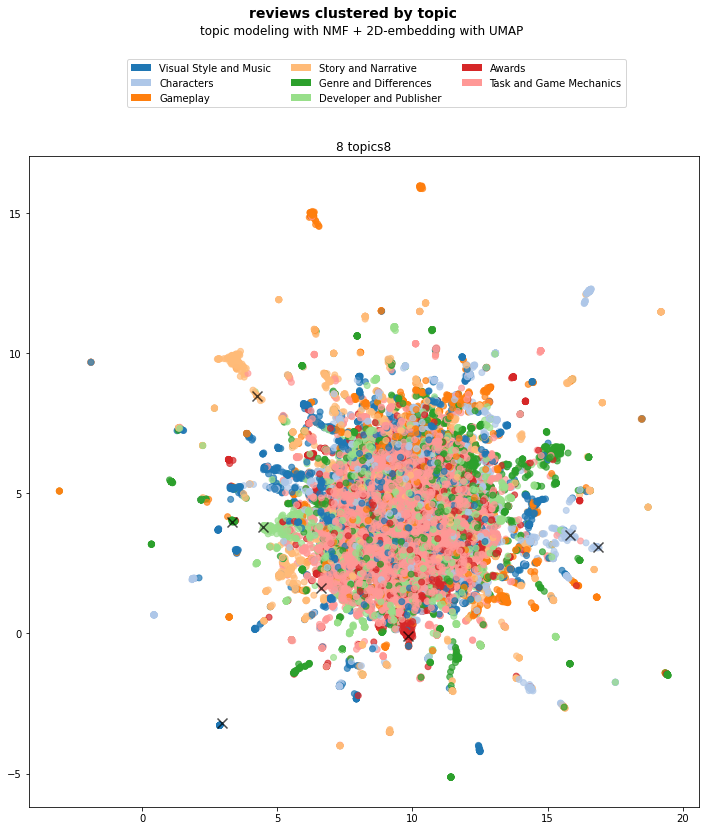

In [51]:
topics = list(topic_dict.values())
legend_list = []
for color in all_palettes['Category20'][20][:n_topics]:   
    legend_list.append(mpatches.Ellipse((0, 0), 1, 1, fc=color))
    
fig,ax = plt.subplots(figsize=(12,13))
ax.scatter(embedding.x, embedding.y, c=my_colors, alpha=0.7)
ax.scatter(centroids[:,0], centroids[:,1], c='black', s=100, alpha=0.7, marker='x')
ax.set_title('8 topics8');
fig.legend(legend_list, topics, loc=(0.18,0.87), ncol=3)
plt.subplots_adjust(top=0.82)
plt.suptitle("reviews clustered by topic", **{'fontsize':'14','weight':'bold'});
plt.figtext(.51,0.95, 'topic modeling with NMF + 2D-embedding with UMAP', 
            **{'fontsize':'12','weight':'light'}, ha='center');

### Show the sentiment label by topics

In [52]:
topic_port = {}
for topic in list(topic_dict.values()):
    topic_grouped = data_sk[data_sk.Topic.values == topic ]
    topic_port_pos = ((topic_grouped.label.values == 'positive').sum())/topic_grouped.shape[0]
    topic_port_neu = ((topic_grouped.label.values == 'neutral').sum())/topic_grouped.shape[0]
    topic_port_neg = ((topic_grouped.label.values == 'negative').sum())/topic_grouped.shape[0]
    topic_port[topic] = [round(topic_port_pos, 4), round(topic_port_neu, 4), round(topic_port_neg, 4)]
print(topic_port)

{'Visual Style and Music': [0.78, 0.1617, 0.0583], 'Characters': [0.7756, 0.1286, 0.0958], 'Gameplay': [0.8438, 0.0892, 0.067], 'Story and Narrative': [0.8197, 0.1047, 0.0756], 'Genre and Differences': [0.7889, 0.1138, 0.0973], 'Developer and Publisher': [0.6908, 0.2071, 0.102], 'Awards': [0.6858, 0.1908, 0.1234], 'Task and Game Mechanics': [0.643, 0.1843, 0.1727]}


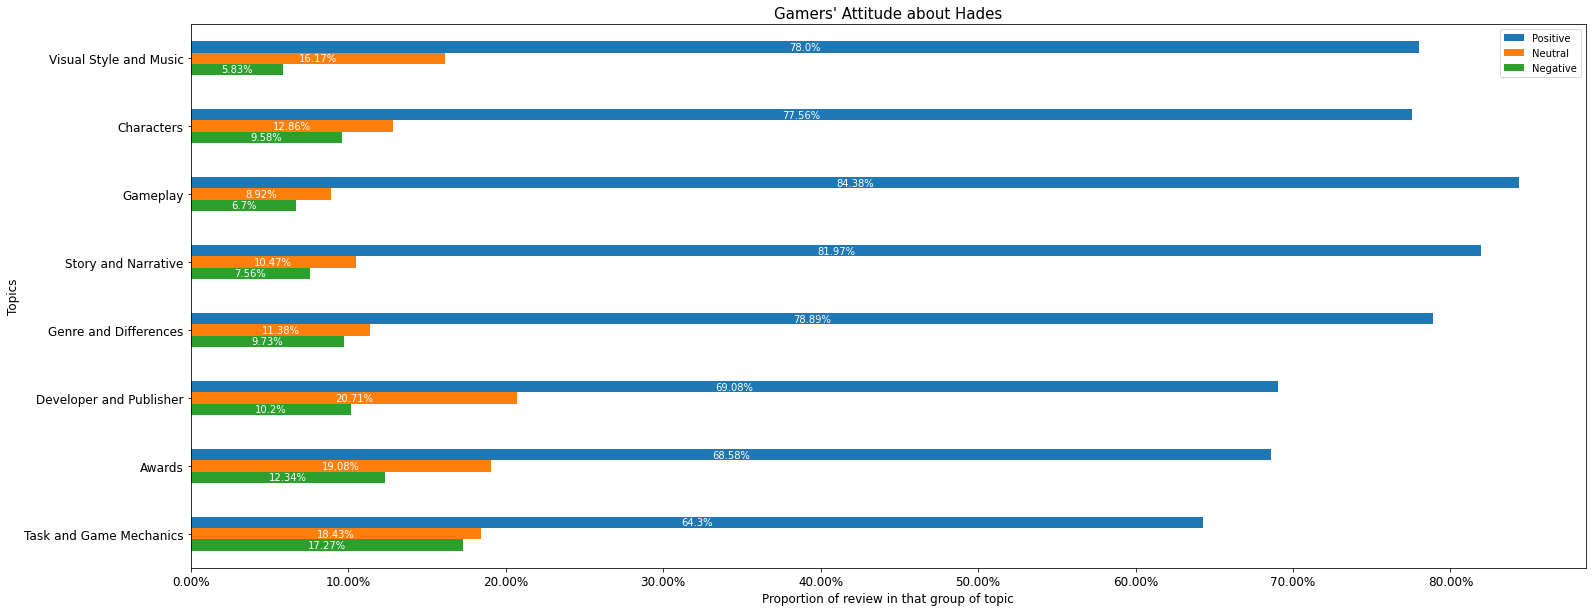

In [60]:
ax = pd.DataFrame(topic_port).T.plot(
    kind='barh',
    figsize = (25,10),
    fontsize = 12
    )
#confirm the value of yaxis would sorted top down
plt.gca().invert_yaxis()
plt.xlabel('Proportion of review in that group of topic', fontsize = 12)
plt.ylabel('Topics', fontsize = 12)
plt.title("Gamers' Attitude about Hades", fontsize = 15)
plt.legend(['Positive', 'Neutral', 'Negative'])
plt.gca().set_xticklabels(['{:.02f}%'.format(x*100) for x in plt.gca().get_xticks()]) 
for l in ax.patches:
    ax.annotate(str(round(l.get_width()*100, 4)) + '%',
                xy=(l.get_x() + l.get_width()/2,
                    l.get_y() + l.get_height()/2),
                ha='center', va='center',
                fontsize=10,
                color='white'
                )

### Validation